In [15]:
#imports.
import numpy as np
import matplotlib.pyplot as plt
import urllib
from collections import Counter

In [16]:
#retriving the data set from the source.
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

urllib.request.urlretrieve(url, 'mnist.npz')

with np.load('mnist.npz') as data:
    train_images = data['x_train']
    train_labels = data['y_train']
    test_images = data['x_test']
    test_labels = data['y_test']

In [17]:
test_image_zero = []
test_image_one = []

for index, img in enumerate(test_images):
  if(test_labels[index]==0):
    test_image_zero.append(img)
  elif(test_labels[index]==1):
    test_image_one.append(img)


test_image_zero=np.array(test_image_zero)
test_image_one=np.array(test_image_one)

In [18]:
image_zero  = []
image_one = []

for index,img in enumerate(train_images):
  if(train_labels[index]==0):
    image_zero.append(img)

for index,img in enumerate(train_images):
  if(train_labels[index]==1):
    image_one.append(img)

val_zero = image_zero[:1000]
val_one = image_one[:1000]
image_zero = image_zero[1000:]
image_one = image_one[1000:]

val_zero = np.array(val_zero)
val_one = np.array(val_one)

image_zero = np.array(image_zero)  #image_zero consists of Number_of_zero_image times (28,28) matrices
image_one = np.array(image_one)   #image_one consists of Number_of_one_image times (28,28) matrices

In [19]:
#Vectorizing the test images


test_image_zero = test_image_zero.reshape(len(test_image_zero),784)
test_image_one = test_image_one.reshape(len(test_image_one),784)

test_dataset = []

for img in test_image_zero:
  test_dataset.append(img)

for img in test_image_one:
  test_dataset.append(img)

test_dataset = np.array(test_dataset).T
test_image_labels = np.array([-1]*len(test_image_zero)+[1]*len(test_image_one))

In [20]:
#Vectorizing the train Images
image_zero = image_zero.reshape(len(image_zero),784)
image_one = image_one.reshape(len(image_one),784)

train_dataset = []
train_dataset_labels = np.array([-1]*len(image_zero)+[1]*len(image_one))

for img in image_zero:
  train_dataset.append(img)

for img in image_one:
  train_dataset.append(img)

train_dataset = np.array(train_dataset).T

In [21]:
#Vectorizing the Val Images
val_zero = val_zero.reshape(len(val_zero),784)
val_one = val_one.reshape(len(val_one),784)

val_dataset_labels = np.array([-1]*len(val_zero)+[1]*len(val_one))
val_dataset = []

for img in val_zero:
  val_dataset.append(img)

for img in val_one:
  val_dataset.append(img)

val_dataset = np.array(val_dataset).T

In [22]:
def principal_component_analysis(dataset,p):
  #Calculating the mean of the dataset and centralizing the dataset
  mean = np.mean(dataset,axis=1,keepdims=True)
  centralized_dataset = dataset - mean

  #calculating covariance matrix , eigenvectors and respective eigenvalues.
  unbiased_cov = np.matmul(centralized_dataset,centralized_dataset.T)/((dataset.shape)[1]-1)
  eigenvalues , eigenvectors = np.linalg.eigh(unbiased_cov)

  sorted_indices = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]

  #Calculating the reduced datamatrix
  principal_components = sorted_eigenvectors[:, :p]
  return np.matmul(principal_components.T,dataset),principal_components

In [23]:
#Obtaining PCA reduced matrix for val set
Y_val , U_val = principal_component_analysis(val_dataset,5)
Y_val = Y_val.T

#Obtaining PCA reduced matrix for train set
Y_train , U_train = principal_component_analysis(train_dataset,5)
Y_train = Y_train.T

#Obtaining the PCA reduced matrix for test set

Y_test , U_test = principal_component_analysis(test_dataset,5)
Y_test = Y_test.T

In [24]:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y, weights):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y,0, weights)

    def _grow_tree(self, X, y, depth=0, weights=None):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        # Check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs, weights)

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1, weights[left_idxs])
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1, weights[right_idxs])
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs, weights, n_random_splits=10):
            least_gain = float('inf')
            split_idx, split_threshold = None, None

            for feat_idx in feat_idxs:
                X_column = X[:, feat_idx]
                thresholds = np.unique(X_column)

                # Calculate midpoints between consecutive unique thresholds
                midpoints = (thresholds[:-1] + thresholds[1:]) / 2

                # Randomly sample up to `n_random_splits` midpoints
                if len(midpoints) > n_random_splits:
                    random_indices = np.random.choice(len(midpoints), n_random_splits, replace=False)
                    sampled_midpoints = midpoints[random_indices]
                else:
                    # Use all available midpoints if there are fewer than `n_random_splits`
                    sampled_midpoints = midpoints

                # Iterate through each sampled midpoint
                for thr in sampled_midpoints:
                    # Calculate the information gain for the current threshold
                    err = self.misclassification(y, X_column, thr, weights)

                    # Update least gain, split index, and split threshold if necessary
                    if err < least_gain:
                        least_gain = err
                        split_idx = feat_idx
                        split_threshold = thr

            return split_idx, split_threshold

    def misclassification(self, y, X_column, threshold, weights):
        total_weight = np.sum(weights)
        left_idx = X_column <= threshold
        right_idx = X_column > threshold
        left_label = y[left_idx]
        right_label = y[right_idx]
        error = 0
        left_ans = self._most_common_label(left_label)
        right_ans = self._most_common_label(right_label)

        for i in range(len(X_column)):
            if X_column[i] <= threshold and y[i] != left_ans:
                error += weights[i]
            elif X_column[i] > threshold and y[i] != right_ans:
                error += weights[i]
            else:
                # Classified correctly
                pass

        #error = error / total_weight
        return error

    def _split(self, X_column, split_thresh):
        left_idxs = X_column <= split_thresh
        right_idxs = X_column > split_thresh
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [25]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

In [26]:
weight = np.full(len(train_dataset_labels),1/len(train_dataset_labels))

clf = DecisionTree(2,1,5)
clf.fit(Y_train,train_dataset_labels,weight)
res = clf.predict(Y_val)
print(accuracy(res,val_dataset_labels))




0.9415


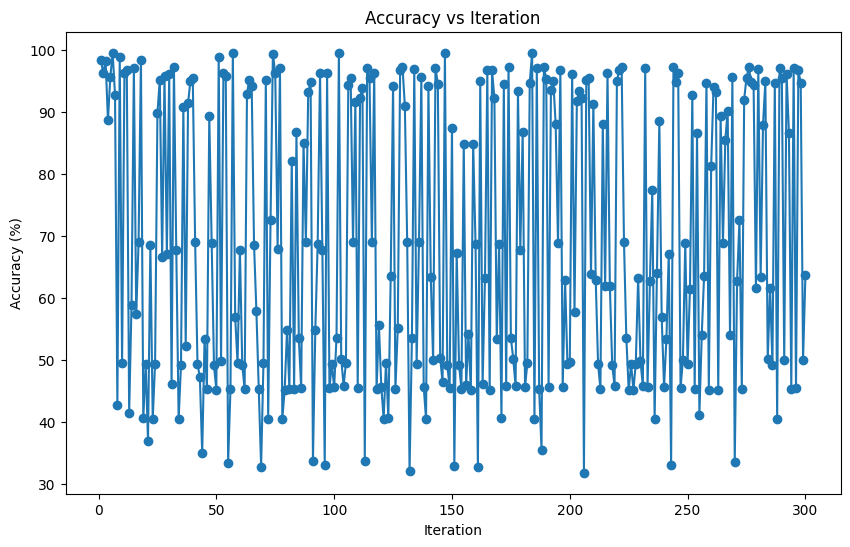

In [27]:
class AdaBoost:
    def __init__(self, base_classifier, n_iterations):
        self.base_classifier = base_classifier  # The base classifier (e.g., DecisionTree)
        self.n_iterations = n_iterations  # Number of boosting iterations
        self.classifiers = []  # List of classifiers
        self.classifier_weights = []  # List of classifier weights
        self.accuracies = []  # List of accuracies (in percentage)

    def fit(self, X_train, y_train, X_val, y_val):
        n_samples = len(y_train)
        # Initialize sample weights
        sample_weights = np.ones(n_samples) / n_samples

        # Boosting iterations
        for iteration in range(self.n_iterations):
            # Train the base classifier with sample weights
            classifier = self.base_classifier
            classifier.fit(X_train, y_train, sample_weights)

            # Make predictions
            predictions_train = classifier.predict(X_train)
            predictions_val = classifier.predict(X_val)

            # Calculate the weighted error rate
            incorrect = (predictions_train != y_train)
            error_rate = np.sum(sample_weights * incorrect) / np.sum(sample_weights)

            # Calculate the classifier's weight
            classifier_weight = 0.5 * np.log((1 - error_rate) / error_rate)
            classifier_weight = np.exp(classifier_weight)
            # Update sample weights
            for i in range(len(y_train)):
              if(predictions_train[i]!=y_train[i]):
                sample_weights[i]=sample_weights[i]*classifier_weight

            # Normalize sample weights so that they sum to 1
            sample_weights /= np.sum(sample_weights)

            # Store the classifier and its weight
            self.classifiers.append(classifier)
            self.classifier_weights.append(classifier_weight)

            # Calculate the accuracy on the validation dataset
            accuracy = np.mean(predictions_val == y_val) * 100  # Convert to percentage
            self.accuracies.append(accuracy)

    '''def predict(self, X):
        # Aggregate predictions from all classifiers
        predictions = np.zeros(X.shape[0])
        for classifier, weight in zip(self.classifiers, self.classifier_weights):
            predictions += weight * classifier.predict(X)

        # Return the final prediction based on the sign of the aggregate
        return np.sign(predictions)'''

# Initialize a DecisionTree as the base classifier
base_classifier = DecisionTree(2,1,5)

# Create an instance of AdaBoost with the base classifier and 300 iterations
adaboost = AdaBoost(base_classifier, n_iterations=300)

# Assuming Y_train, Y_val, train_dataset_labels, and val_dataset_labels are defined
adaboost.fit(Y_train, train_dataset_labels, Y_val, val_dataset_labels)

# Plot accuracy versus iteration count
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(adaboost.accuracies) + 1), adaboost.accuracies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Iteration')
plt.show()


In [28]:
max_index = np.argmax(adaboost.accuracies)
print(adaboost.accuracies[max_index])
print("final indes: ",max_index)
final_classifier = adaboost.classifiers[max_index]

print(100*accuracy(final_classifier.predict(Y_test),test_image_labels))

99.55000000000001
final indes:  56
69.9290780141844
